In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
import h5py
import sklearn
import time
import datetime
import pytz
from mlxtend.plotting import plot_decision_regions

In [60]:
!python --version

Python 3.6.9


In [64]:
print('TF version:', tf.__version__)
print('Numpy version:', np.__version__)
print('Matplotlib version:', matplotlib.__version__)

TF version: 2.3.0
Numpy version: 1.18.5
Matplotlib version: 3.2.2


# 3.0 Case study I: signs dataset

## 3.1 Introduction


One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the [SIGNS dataset](https://www.kaggle.com/datamunge/sign-language-mnist). The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.


<center><img width="600" src="https://drive.google.com/uc?export=view&id=1Qz_B0IjzLrp77cBWIz6DVTsG3l9PSFKr"></center>
<center><b>Figure 1</b>: SIGNS dataset <br></center>


In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import time
import datetime
import pytz
from mlxtend.plotting import plot_decision_regions

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



Run the following code to load the dataset.

In [43]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [44]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


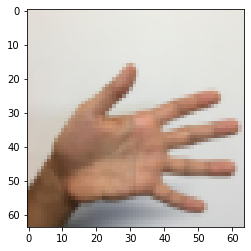

In [45]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [46]:
# Normalize image vectors
train_x = X_train_orig/255.
test_x = X_test_orig/255.
# Convert training and test labels to one hot matrices
train_y = tf.keras.utils.to_categorical(Y_train_orig).squeeze()
test_y = tf.keras.utils.to_categorical(Y_test_orig).squeeze()

print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 3.2 - Callback and helper functions

In [47]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))
    print('Duration: {}s'.format(time.time() - self.begins))

In [48]:
def print_analysis(titles,history):
  loss = ["loss", "val_loss"]
  accuracy = ["categorical_accuracy","val_categorical_accuracy"]
  f, axs = plt.subplots(1,2,figsize=(10,4))
  
  for i,item in enumerate([loss,accuracy]):
    axs[i].plot(history.history[item[0]])
    axs[i].plot(history.history[item[1]])
    axs[i].set_ylabel(item[0])
    axs[i].set_xlabel('epoch')
    axs[i].legend(['train', 'test'], loc='best')
    if i == 1:
      axs[i].set_ylim(0,1)

  f.suptitle(titles, y=1.1)
  plt.tight_layout()
  plt.show()

## 3.3 Baseline Model

In [49]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)

# Normalize image vectors
train_base_x = X_train_flatten/255.
test_base_x = X_test_flatten/255.
# Convert training and test labels to one hot matrices
train_y = tf.keras.utils.to_categorical(Y_train_orig).squeeze()
test_y = tf.keras.utils.to_categorical(Y_test_orig).squeeze()

print ("number of training examples = " + str(train_base_x.shape[0]))
print ("number of test examples = " + str(test_base_x.shape[0]))
print ("X_train shape: " + str(train_base_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_base_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 12288)
Y_train shape: (1080, 6)
X_test shape: (120, 12288)
Y_test shape: (120, 6)


In [50]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(25, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(6, activation = tf.nn.softmax,kernel_initializer="he_uniform")
                             ])

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_base_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_base_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 2020-11-20 15:51:08
Training: ends at 2020-11-20 15:53:56
Duration: 167.84661889076233s


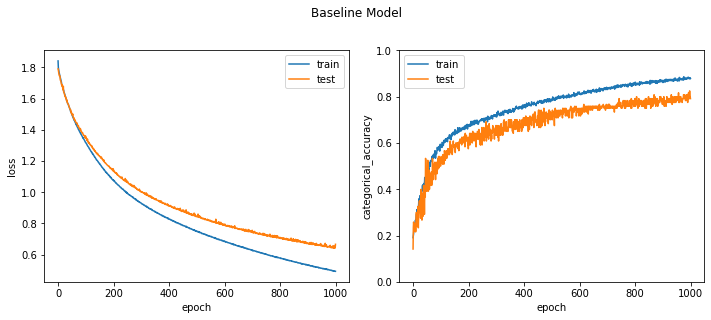

In [51]:
print_analysis("Baseline Model", history)

In [52]:
loss, acc = model.evaluate(x=train_base_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_base_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 3ms/step - loss: 0.5001 - categorical_accuracy: 0.8824
Train loss: 0.500 - acc: 0.882
4/4 [==============================] - 0s 3ms/step - loss: 0.6657 - categorical_accuracy: 0.7917
Test loss: 0.666 - acc: 0.792


In [53]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                307225    
_________________________________________________________________
dense_5 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 78        
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________


## 3.4 CNN Model

In [54]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (5,5), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Conv2D(32, (5,5), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                

In [55]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-20 15:53:57
Epoch 1/100
34/34 [==============================] - 3s 101ms/step - loss: 1.7855 - categorical_accuracy: 0.2074 - val_loss: 1.7658 - val_categorical_accuracy: 0.2750
Epoch 2/100
34/34 [==============================] - 3s 96ms/step - loss: 1.6857 - categorical_accuracy: 0.3852 - val_loss: 1.6419 - val_categorical_accuracy: 0.4333
Epoch 3/100
34/34 [==============================] - 3s 94ms/step - loss: 1.5487 - categorical_accuracy: 0.5352 - val_loss: 1.5253 - val_categorical_accuracy: 0.5500
Epoch 4/100
34/34 [==============================] - 3s 96ms/step - loss: 1.4306 - categorical_accuracy: 0.6546 - val_loss: 1.4594 - val_categorical_accuracy: 0.6083
Epoch 5/100
34/34 [==============================] - 3s 95ms/step - loss: 1.3904 - categorical_accuracy: 0.6917 - val_loss: 1.3767 - val_categorical_accuracy: 0.6833
Epoch 6/100
34/34 [==============================] - 3s 94ms/step - loss: 1.3389 - categorical_accuracy: 0.7333 - val_loss: 1.353

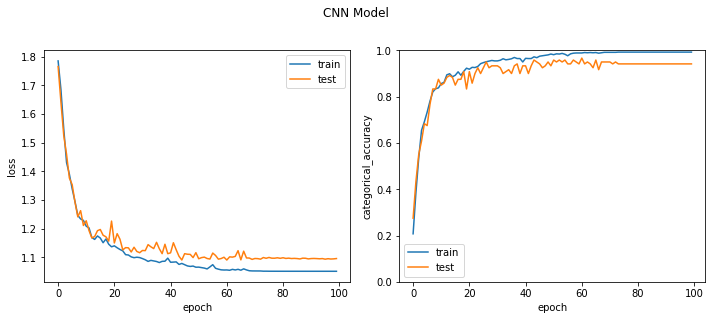

In [56]:
print_analysis("CNN Model", history)

In [57]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 1s 32ms/step - loss: 1.0510 - categorical_accuracy: 0.9926
Train loss: 1.051 - acc: 0.993
4/4 [==============================] - 0s 23ms/step - loss: 1.0954 - categorical_accuracy: 0.9417
Test loss: 1.095 - acc: 0.942


## 3.5 - Test with your own image

You can now take a picture of your hand and see the output of your model.

float32
(1, 64, 64, 3)


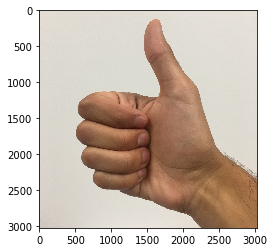

In [58]:
# example of converting an image with the Keras API
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.transform import resize

# load the image
img = load_img('thumbs_up.jpg')

# convert to numpy array
img_array = img_to_array(img)/255
img_array_res = resize(img_array, (64,64)).reshape((1, 64,64,3))

print(img_array_res.dtype)
print(img_array_res.shape)

plt.imshow(img_array)

In [59]:
model.predict(img_array_res).argmax()

3

# Models

## Model 01 (Basic)

In [65]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (5,5), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Conv2D(32, (5,5), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_10 (Dense)             (None, 6)                

In [66]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-20 17:19:06
Epoch 1/100
34/34 [==============================] - 3s 102ms/step - loss: 1.7875 - categorical_accuracy: 0.2074 - val_loss: 1.7703 - val_categorical_accuracy: 0.3417
Epoch 2/100
34/34 [==============================] - 3s 97ms/step - loss: 1.6947 - categorical_accuracy: 0.3685 - val_loss: 1.6279 - val_categorical_accuracy: 0.4000
Epoch 3/100
34/34 [==============================] - 3s 95ms/step - loss: 1.5601 - categorical_accuracy: 0.4880 - val_loss: 1.5075 - val_categorical_accuracy: 0.5667
Epoch 4/100
34/34 [==============================] - 3s 96ms/step - loss: 1.4374 - categorical_accuracy: 0.6583 - val_loss: 1.4255 - val_categorical_accuracy: 0.6583
Epoch 5/100
34/34 [==============================] - 3s 96ms/step - loss: 1.3708 - categorical_accuracy: 0.7056 - val_loss: 1.3809 - val_categorical_accuracy: 0.6500
Epoch 6/100
34/34 [==============================] - 3s 96ms/step - loss: 1.3335 - categorical_accuracy: 0.7389 - val_loss: 1.373

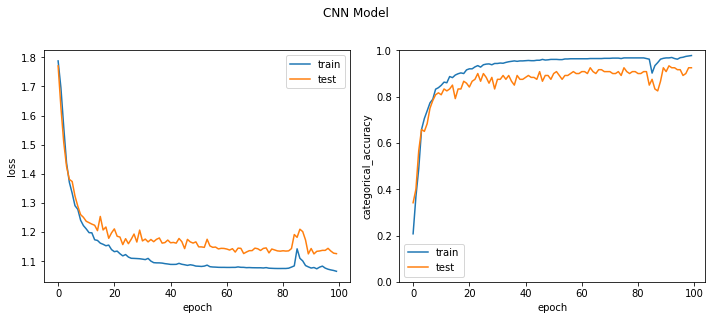

In [67]:
print_analysis("CNN Model", history)

In [68]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 1s 32ms/step - loss: 1.0649 - categorical_accuracy: 0.9787
Train loss: 1.065 - acc: 0.979
4/4 [==============================] - 0s 27ms/step - loss: 1.1260 - categorical_accuracy: 0.9250
Test loss: 1.126 - acc: 0.925


## Model 02 (Dropout)

In [107]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 12, 12, 64)      

In [108]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=64,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-20 18:30:13
Epoch 1/100
17/17 [==============================] - 4s 257ms/step - loss: 1.7948 - categorical_accuracy: 0.1509 - val_loss: 1.7917 - val_categorical_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 4s 222ms/step - loss: 1.7922 - categorical_accuracy: 0.1685 - val_loss: 1.7917 - val_categorical_accuracy: 0.1750
Epoch 3/100
17/17 [==============================] - 4s 221ms/step - loss: 1.7914 - categorical_accuracy: 0.1667 - val_loss: 1.7915 - val_categorical_accuracy: 0.1667
Epoch 4/100
17/17 [==============================] - 4s 222ms/step - loss: 1.7921 - categorical_accuracy: 0.1713 - val_loss: 1.7913 - val_categorical_accuracy: 0.1667
Epoch 5/100
17/17 [==============================] - 4s 220ms/step - loss: 1.7909 - categorical_accuracy: 0.1769 - val_loss: 1.7907 - val_categorical_accuracy: 0.2250
Epoch 6/100
17/17 [==============================] - 4s 220ms/step - loss: 1.7866 - categorical_accuracy: 0.2157 - val_loss: 

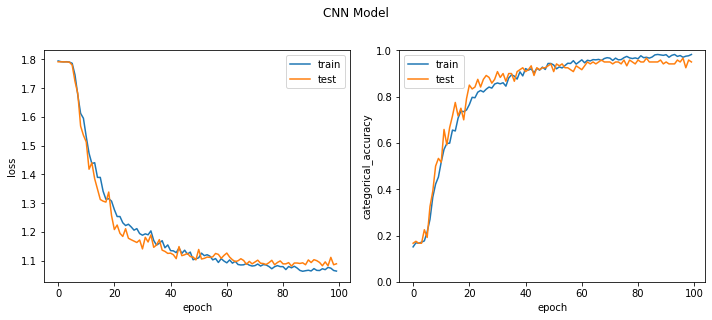

In [109]:
print_analysis("CNN Model", history)

In [110]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 1s 35ms/step - loss: 1.0492 - categorical_accuracy: 0.9954
Train loss: 1.049 - acc: 0.995
4/4 [==============================] - 0s 25ms/step - loss: 1.0895 - categorical_accuracy: 0.9500
Test loss: 1.089 - acc: 0.950


## Model 03 (BatchNormalization)

In [132]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.BatchNormalization(),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax),
])

model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
batch_normalization_100 (Bat (None, 31, 31, 16)        64        
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 14, 14, 32)        128       
_________________________________________________________________
flatten_35 (Flatten)         (None, 6272)            

In [118]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=64,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-20 18:46:53
Epoch 1/100
17/17 [==============================] - 4s 212ms/step - loss: 1.5787 - categorical_accuracy: 0.4398 - val_loss: 1.7752 - val_categorical_accuracy: 0.1750
Epoch 2/100
17/17 [==============================] - 3s 181ms/step - loss: 1.2589 - categorical_accuracy: 0.7954 - val_loss: 1.7625 - val_categorical_accuracy: 0.2250
Epoch 3/100
17/17 [==============================] - 3s 180ms/step - loss: 1.1505 - categorical_accuracy: 0.9019 - val_loss: 1.7416 - val_categorical_accuracy: 0.2917
Epoch 4/100
17/17 [==============================] - 3s 181ms/step - loss: 1.0995 - categorical_accuracy: 0.9491 - val_loss: 1.7311 - val_categorical_accuracy: 0.3167
Epoch 5/100
17/17 [==============================] - 3s 180ms/step - loss: 1.0808 - categorical_accuracy: 0.9639 - val_loss: 1.7152 - val_categorical_accuracy: 0.3583
Epoch 6/100
17/17 [==============================] - 3s 185ms/step - loss: 1.0710 - categorical_accuracy: 0.9741 - val_loss: 

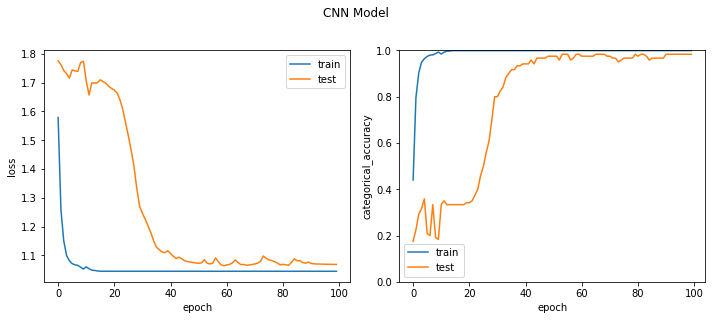

In [119]:
print_analysis("CNN Model", history)

In [120]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 1s 31ms/step - loss: 1.0445 - categorical_accuracy: 0.9991
Train loss: 1.045 - acc: 0.999
4/4 [==============================] - 0s 23ms/step - loss: 1.0683 - categorical_accuracy: 0.9833
Test loss: 1.068 - acc: 0.983


# Models (sem CNN)

## Model 01 (Basic)

In [139]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(64,64,3)),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_78 (Dense)             (None, 64)                786496    
_________________________________________________________________
dense_79 (Dense)             (None, 6)                 390       
Total params: 786,886
Trainable params: 786,886
Non-trainable params: 0
_________________________________________________________________


In [140]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-20 19:51:51
Epoch 1/100
34/34 [==============================] - 0s 12ms/step - loss: 1.8786 - categorical_accuracy: 0.1611 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 2/100
34/34 [==============================] - 0s 8ms/step - loss: 1.8769 - categorical_accuracy: 0.1667 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 3/100
34/34 [==============================] - 0s 8ms/step - loss: 1.8769 - categorical_accuracy: 0.1667 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 4/100
34/34 [==============================] - 0s 8ms/step - loss: 1.8769 - categorical_accuracy: 0.1667 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 5/100
34/34 [==============================] - 0s 8ms/step - loss: 1.8769 - categorical_accuracy: 0.1667 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 6/100
34/34 [==============================] - 0s 8ms/step - loss: 1.8769 - categorical_accuracy: 0.1667 - val_loss: 1.8769 - va

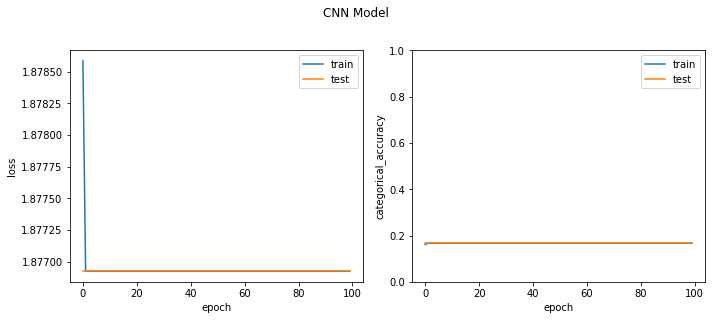

In [141]:
print_analysis("CNN Model", history)

In [142]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 4ms/step - loss: 1.8769 - categorical_accuracy: 0.1667
Train loss: 1.877 - acc: 0.167
4/4 [==============================] - 0s 3ms/step - loss: 1.8769 - categorical_accuracy: 0.1667
Test loss: 1.877 - acc: 0.167


## Model 02 (Dropout)

In [143]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(64,64,3)),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_80 (Dense)             (None, 64)                786496    
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 6)                 390       
Total params: 786,886
Trainable params: 786,886
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=64,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-20 19:52:24
Epoch 1/100
17/17 [==============================] - 0s 21ms/step - loss: 1.8661 - categorical_accuracy: 0.1694 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 0s 13ms/step - loss: 1.8764 - categorical_accuracy: 0.1657 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 1.8789 - categorical_accuracy: 0.1648 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 1.8776 - categorical_accuracy: 0.1657 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 1.8785 - categorical_accuracy: 0.1648 - val_loss: 1.8769 - val_categorical_accuracy: 0.1667
Epoch 6/100
17/17 [==============================] - 0s 15ms/step - loss: 1.8789 - categorical_accuracy: 0.1648 - val_loss: 1.8769

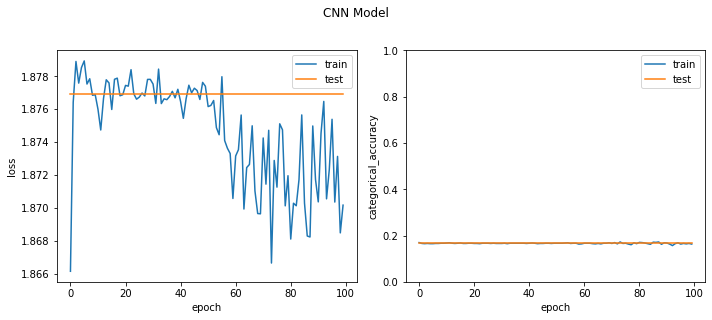

In [145]:
print_analysis("CNN Model", history)

In [146]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 3ms/step - loss: 1.8769 - categorical_accuracy: 0.1667
Train loss: 1.877 - acc: 0.167
4/4 [==============================] - 0s 3ms/step - loss: 1.8769 - categorical_accuracy: 0.1667
Test loss: 1.877 - acc: 0.167


## Model 03 (BatchNormalization)

In [152]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(64,64,3)),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax),
])

model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_42 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_86 (Dense)             (None, 64)                786496    
_________________________________________________________________
batch_normalization_104 (Bat (None, 64)                256       
_________________________________________________________________
dense_87 (Dense)             (None, 6)                 390       
Total params: 787,142
Trainable params: 787,014
Non-trainable params: 128
_________________________________________________________________


In [148]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=64,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-20 19:52:50
Epoch 1/100
17/17 [==============================] - 0s 20ms/step - loss: 1.5565 - categorical_accuracy: 0.5204 - val_loss: 1.8160 - val_categorical_accuracy: 0.2000
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 1.3903 - categorical_accuracy: 0.7407 - val_loss: 1.7993 - val_categorical_accuracy: 0.2250
Epoch 3/100
17/17 [==============================] - 0s 12ms/step - loss: 1.3181 - categorical_accuracy: 0.8148 - val_loss: 1.8760 - val_categorical_accuracy: 0.1667
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 1.2667 - categorical_accuracy: 0.8556 - val_loss: 1.8459 - val_categorical_accuracy: 0.1833
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 1.2265 - categorical_accuracy: 0.8889 - val_loss: 1.7774 - val_categorical_accuracy: 0.2333
Epoch 6/100
17/17 [==============================] - 0s 11ms/step - loss: 1.1991 - categorical_accuracy: 0.9148 - val_loss: 1.8752

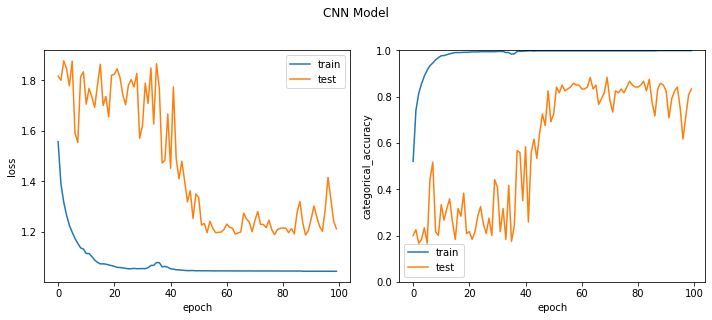

In [149]:
print_analysis("CNN Model", history)

In [150]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 3ms/step - loss: 1.0454 - categorical_accuracy: 0.9991
Train loss: 1.045 - acc: 0.999
4/4 [==============================] - 0s 3ms/step - loss: 1.2124 - categorical_accuracy: 0.8333
Test loss: 1.212 - acc: 0.833


# Models (Hiperparametros)

In [122]:
from tensorboard.plugins.hparams import api as hp

In [154]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 64]))
HP_KERNEL = hp.HParam('kernel', hp.Discrete([3, 5]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.3))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_KERNEL, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [155]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [160]:
def call_hparam_tuning():
  session_num = 0

  for num_units in HP_NUM_UNITS.domain.values:
    for kernel in HP_KERNEL.domain.values:
      for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        hparams = {
            HP_NUM_UNITS: num_units,
            HP_KERNEL: kernel,
            HP_DROPOUT: dropout_rate,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

## Model 01 (Basic)

In [158]:
def train_test_model(hparams):
  kernel = hparams[HP_KERNEL]

  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (kernel, kernel), activation=tf.nn.relu, input_shape=(64,64,3)),
    tf.keras.layers.MaxPool2D((3,3)),
    tf.keras.layers.Conv2D(32, (kernel, kernel), activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D((3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
  ])

  # Instantiate a logistic loss function
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

  # Instantiate an accuracy metric.
  accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Instantiate an optimizer.
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  # configure the optimizer, loss, and metrics to monitor.
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

  # training 
  model.fit(x=train_x,
            y=train_y,
            batch_size=64,
            epochs=100,
            validation_data=(test_x,test_y),
            callbacks=[MyCustomCallback()],
            verbose=1)
  _, accuracy = model.evaluate(test_x, test_y)
  return accuracy

In [161]:
call_hparam_tuning()

--- Starting trial: run-0
{'num_units': 16, 'kernel': 3, 'dropout': 0.2}
Training: begins at 2020-11-20 20:20:23
Epoch 1/100
17/17 [==============================] - 2s 131ms/step - loss: 1.7905 - categorical_accuracy: 0.1694 - val_loss: 1.7865 - val_categorical_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 2s 121ms/step - loss: 1.7808 - categorical_accuracy: 0.2500 - val_loss: 1.7695 - val_categorical_accuracy: 0.3250
Epoch 3/100
17/17 [==============================] - 2s 124ms/step - loss: 1.7532 - categorical_accuracy: 0.3324 - val_loss: 1.7330 - val_categorical_accuracy: 0.3417
Epoch 4/100
17/17 [==============================] - 2s 122ms/step - loss: 1.7014 - categorical_accuracy: 0.3722 - val_loss: 1.6893 - val_categorical_accuracy: 0.3417
Epoch 5/100
17/17 [==============================] - 2s 119ms/step - loss: 1.6333 - categorical_accuracy: 0.4583 - val_loss: 1.6234 - val_categorical_accuracy: 0.4750
Epoch 6/100
17/17 [==============================] -

## Model 02 (Dropout)

In [162]:
def train_test_model(hparams):
  kernel = hparams[HP_KERNEL]
  dropout = hparams[HP_DROPOUT]
  num_units = hparams[HP_NUM_UNITS]

  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (kernel,kernel), activation=tf.nn.relu, input_shape=(64,64,3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(32, (kernel,kernel), activation=tf.nn.relu, input_shape=(64,64,3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(64, (kernel,kernel), activation=tf.nn.relu, input_shape=(64,64,3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(128, (kernel,kernel), activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
  ])

  # Instantiate a logistic loss function
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

  # Instantiate an accuracy metric.
  accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Instantiate an optimizer.
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  # configure the optimizer, loss, and metrics to monitor.
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

  # training 
  model.fit(x=train_x,
            y=train_y,
            batch_size=64,
            epochs=100,
            validation_data=(test_x,test_y),
            callbacks=[MyCustomCallback()],
            verbose=1)
  _, accuracy = model.evaluate(test_x, test_y)
  return accuracy

In [163]:
call_hparam_tuning()

--- Starting trial: run-0
{'num_units': 16, 'kernel': 3, 'dropout': 0.2}
Training: begins at 2020-11-20 21:18:14
Epoch 1/100
17/17 [==============================] - 4s 248ms/step - loss: 1.7921 - categorical_accuracy: 0.1667 - val_loss: 1.7915 - val_categorical_accuracy: 0.2000
Epoch 2/100
17/17 [==============================] - 4s 249ms/step - loss: 1.7918 - categorical_accuracy: 0.1676 - val_loss: 1.7909 - val_categorical_accuracy: 0.1667
Epoch 3/100
17/17 [==============================] - 4s 247ms/step - loss: 1.7891 - categorical_accuracy: 0.1769 - val_loss: 1.7882 - val_categorical_accuracy: 0.1667
Epoch 4/100
17/17 [==============================] - 4s 242ms/step - loss: 1.7792 - categorical_accuracy: 0.1972 - val_loss: 1.7720 - val_categorical_accuracy: 0.2917
Epoch 5/100
17/17 [==============================] - 4s 225ms/step - loss: 1.7522 - categorical_accuracy: 0.2602 - val_loss: 1.7484 - val_categorical_accuracy: 0.3000
Epoch 6/100
17/17 [==============================] -

ValueError: ignored

## Model 03 (BatchNormalization)

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.BatchNormalization(),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 31, 31, 16)        64        
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
flatten_28 (Flatten)         (None, 6272)            

In [ ]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=64,
                    epochs=100,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-20 18:46:53
Epoch 1/100
17/17 [==============================] - 4s 212ms/step - loss: 1.5787 - categorical_accuracy: 0.4398 - val_loss: 1.7752 - val_categorical_accuracy: 0.1750
Epoch 2/100
17/17 [==============================] - 3s 181ms/step - loss: 1.2589 - categorical_accuracy: 0.7954 - val_loss: 1.7625 - val_categorical_accuracy: 0.2250
Epoch 3/100
17/17 [==============================] - 3s 180ms/step - loss: 1.1505 - categorical_accuracy: 0.9019 - val_loss: 1.7416 - val_categorical_accuracy: 0.2917
Epoch 4/100
17/17 [==============================] - 3s 181ms/step - loss: 1.0995 - categorical_accuracy: 0.9491 - val_loss: 1.7311 - val_categorical_accuracy: 0.3167
Epoch 5/100
17/17 [==============================] - 3s 180ms/step - loss: 1.0808 - categorical_accuracy: 0.9639 - val_loss: 1.7152 - val_categorical_accuracy: 0.3583
Epoch 6/100
17/17 [==============================] - 3s 185ms/step - loss: 1.0710 - categorical_accuracy: 0.9741 - val_loss: 

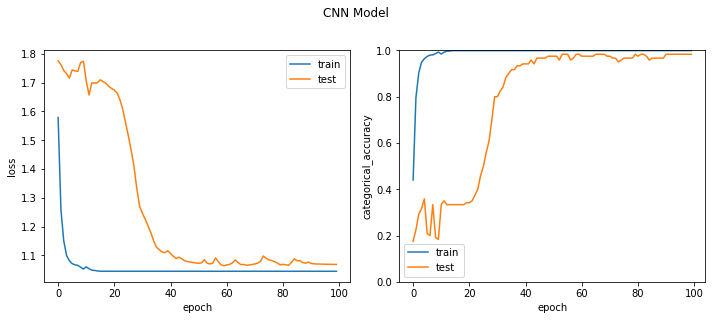

In [ ]:
print_analysis("CNN Model", history)

In [ ]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 1s 31ms/step - loss: 1.0445 - categorical_accuracy: 0.9991
Train loss: 1.045 - acc: 0.999
4/4 [==============================] - 0s 23ms/step - loss: 1.0683 - categorical_accuracy: 0.9833
Test loss: 1.068 - acc: 0.983
